# Word2Vec (Google) : Pré-entraînement sur un corpus en français. 

## Modèles  de Word Embeddings 

In [281]:
# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

In [282]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Télécharger les données nécessaires
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathispappo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [283]:
# Charger les données
file_path = "../tweets_labelled.csv"
df = pd.read_csv(file_path)

### Nettoyage des données

In [284]:
# Supprimer les lien et les emojis
def remove_links(text):
    text = re.sub(r"http\S+", "", text)  # Supprimer les liens
    # text = text.encode('ascii', 'ignore').decode('ascii') # supprimer les emojis
    # text = text.lower()  # Convertir en minuscules
    return text

df['cleaned_text'] = df['Texte'].astype(str).apply(remove_links)

In [285]:
# Fonction pour extraire les mentions sans modifier le reste du texte
def get_mentions(text):
    mentions = re.findall(r"@\S+", text)  # Extraire les mentions
    return mentions

# Fonction pour supprimer les mentions sans affecter les accents
def remove_mentions(text):
    # Utiliser re.sub pour supprimer uniquement les mentions
    return re.sub(r"@\S+", "", text)

# Appliquer sur les données
df['mentions'] = df['cleaned_text'].apply(get_mentions)  # Extraire les mentions
df['cleaned_text'] = df['cleaned_text'].apply(remove_mentions)  # Supprimer les mentions

In [286]:
# afficher les 5 premières lignes
print(df['cleaned_text'].head())

0    le_Parisien :\n"« Je me suis sentie humiliée »...
1    FloPortelli :\n" Ce qui est dingue c’est de po...
2    SAbdelhamid :\n"  Ce qui est dingue c’est qu’o...
3    eve_thefirst :\n"   Personne ne l'empêche de j...
4    ChipeauxMylene :\n"    C est tous à fait ça. D...
Name: cleaned_text, dtype: object


In [287]:
# afficher uniquement les mentions
def mentions(text):
    text = re.findall(r"@\S+", text)  # Trouver les mentions
    return text

# afficher les mentions
print(df['cleaned_text'].apply(mentions).sum())

[]


In [288]:
from collections import Counter
import re

# Fonction pour extraire et compter les caractères spéciaux
def special_characters_count(text):
    # Trouver tous les caractères spéciaux
    special_chars = re.findall(r"[^a-zA-Z0-9\s]", text)
    # Retourner un dictionnaire des occurrences
    return Counter(special_chars)

# Appliquer sur la colonne 'cleaned_text' et agréger les résultats
special_characters_total = df['cleaned_text'].apply(special_characters_count)

# Fusionner tous les comptes en un seul Counter
total_count = Counter()
for count in special_characters_total:
    total_count.update(count)

# Afficher le nombre de chaque caractère spécial
print(total_count)

Counter({'é': 4841, '"': 3955, '.': 3009, ':': 2460, "'": 1993, ',': 1773, '’': 1087, 'à': 991, 'è': 640, '?': 562, '_': 531, '!': 484, '-': 475, 'ê': 405, '#': 329, 'ç': 318, ')': 273, '(': 257, '️': 129, '%': 128, '/': 127, '…': 125, 'ô': 85, 'û': 85, '€': 78, '«': 66, '»': 63, '🤣': 58, '😂': 52, 'É': 49, 'â': 49, '+': 49, 'î': 47, ';': 45, 'ù': 44, 'Ç': 40, '🇷': 34, '&': 30, '🇫': 28, '🤡': 25, '✅': 25, '🤔': 24, '👇': 22, '”': 20, '🙄': 19, '👍': 18, '🚨': 18, '🇪': 18, '➡': 18, '\u200d': 17, '“': 17, 'ï': 16, '=': 16, 'À': 16, '⤵': 15, '*': 15, '😉': 15, '🔴': 15, '⚡': 15, '🇺': 14, '❌': 13, '🏻': 13, '[': 12, ']': 12, '🤦': 12, '🗣': 12, '°': 11, '✈': 11, '👉': 10, '🤷': 10, '🙏': 10, '😅': 10, '⃣': 10, '🚗': 10, '😡': 10, '🇦': 10, '⬇': 9, '😠': 9, '♀': 8, '|': 8, '🙃': 8, 'È': 8, '$': 7, '🇹': 7, 'ë': 7, 'ı': 7, '😘': 6, 'œ': 6, '❤': 6, '♂': 6, '👏': 6, '👎': 6, '🤮': 6, '🚘': 6, '🇸': 6, 'ə': 6, '‘': 5, '🇩': 5, '😤': 5, '💨': 5, '😏': 5, '🇮': 5, '☢': 5, '👻': 5, 'ü': 5, '🇿': 5, '👌': 4, '🧐': 4, '⛽': 4, '📢': 4, '

In [289]:
# Supprimer les caractères spéciaux
def remove_special_characters(text):
    text = re.sub(r"[^a-zA-ZÀ-ÿ\s]", "", text) # Supprimer les caractères spéciaux
    return text

df['cleaned_text'] = df['cleaned_text'].apply(remove_special_characters)

In [290]:
# des données manquantes
print(df.isnull().sum())

Unnamed: 0               0
Index                   48
Texte                   48
Media                 1611
Interaction             54
Sujet                   58
Données manquantes     602
A supprimer            101
cleaned_text             0
mentions                 0
dtype: int64


In [291]:
# Supprimer la colonne Media
df.drop(columns=['Media'], inplace=True)

In [292]:
# Si une ligne a un index manquant, supprimez-le
df.dropna(subset=['Index'], inplace=True)


In [293]:
# des données manquantes
print(df.isnull().sum())

Unnamed: 0              0
Index                   0
Texte                   0
Interaction             6
Sujet                  10
Données manquantes    602
A supprimer           101
cleaned_text            0
mentions                0
dtype: int64


In [294]:
# Supprimer les mots inutiles
stop_words = set(stopwords.words('french'))

def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(text)


df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

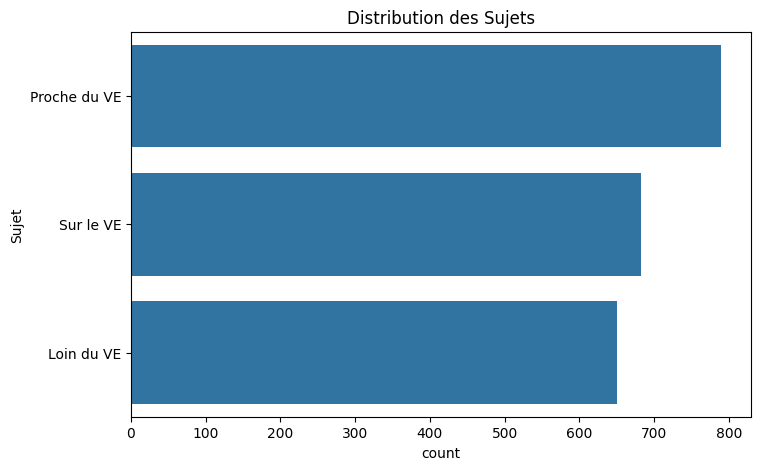

Sujet
Proche du VE    790
Sur le VE       682
Loin du VE      650
Name: count, dtype: int64

In [295]:
# Analyse des catégories (distribution des sujets)
plt.figure(figsize=(8, 5))
sns.countplot(y='Sujet', data=df, order=df['Sujet'].value_counts().index)
plt.title("Distribution des Sujets")
plt.show()

# Analyse des catégories (distribution des sujets) par un tableau
df['Sujet'].value_counts()


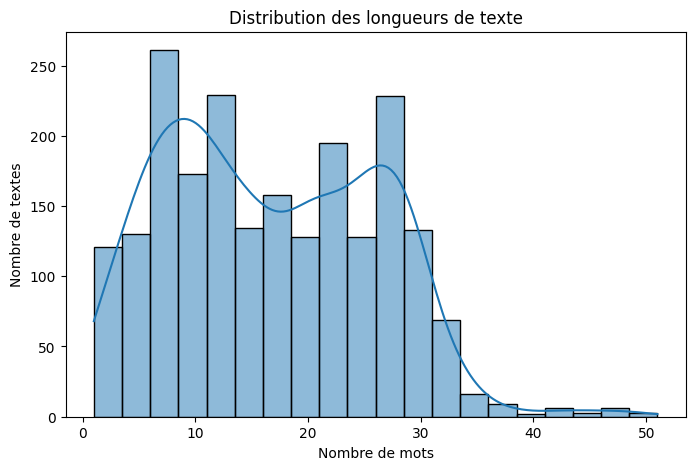

In [296]:
# Analyse des longueurs de texte
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title("Distribution des longueurs de texte")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de textes")
plt.show()

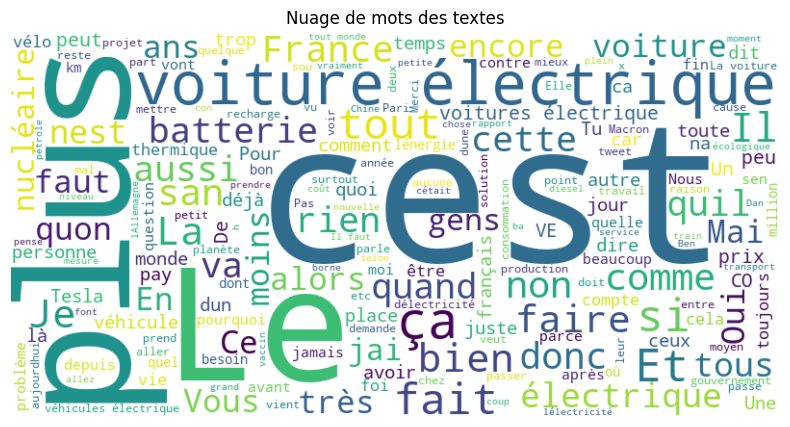

In [297]:
# Nuage de mots (WordCloud)
all_text = " ".join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des textes")
plt.show()

In [298]:
# Fréquences des mots
from collections import Counter

all_words = " ".join(df['cleaned_text']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)

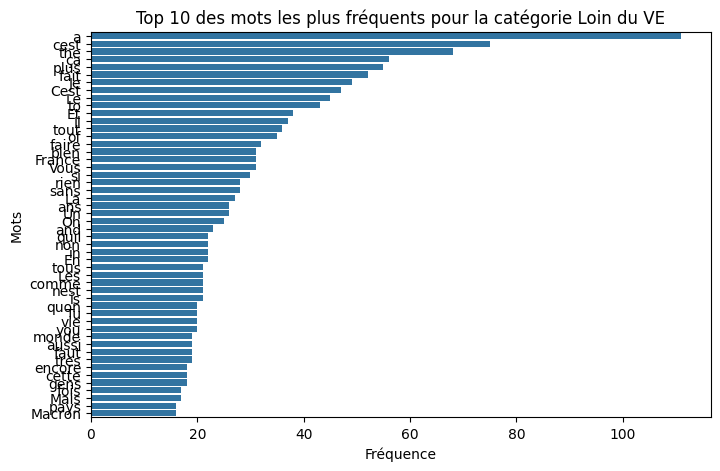

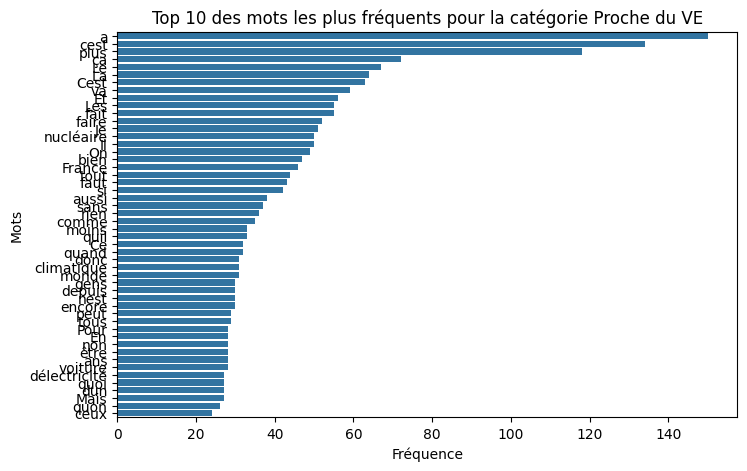

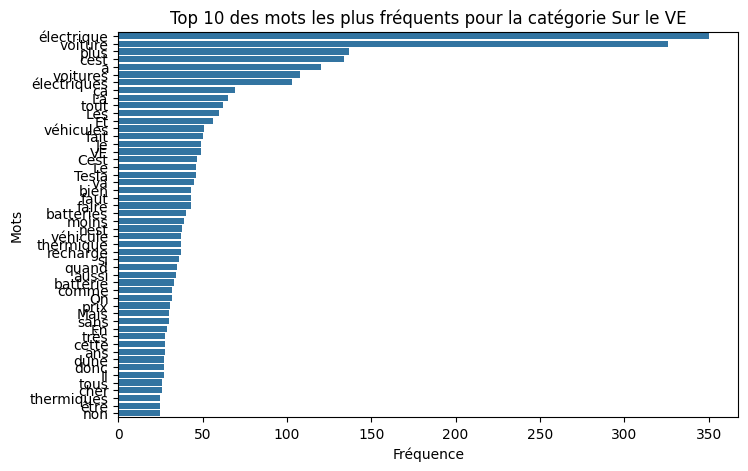

In [299]:
# Afficher les mots les plus fréquents par catégorie
categories = df['Sujet'].unique()

for category in categories:
    text = " ".join(df[df['Sujet'] == category]['cleaned_text']).split()
    word_freq = Counter(text)
    common_words = word_freq.most_common(50)

    if common_words:  # Check if common_words is not empty
        words, counts = zip(*common_words)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(counts), y=list(words))
        plt.title(f"Top 10 des mots les plus fréquents pour la catégorie {category}")
        plt.xlabel("Fréquence")
        plt.ylabel("Mots")
        plt.show()

In [301]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np

# Tokeniser les textes nettoyés
df['tokens'] = df['cleaned_text'].apply(lambda x: word_tokenize(x.lower()))

# Entraîner le modèle Word2Vec
sentences = df['tokens'].tolist()  # Obtenir toutes les phrases tokenisées
model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

# Mots clés pour détecter les tweets sur les voitures électriques
keywords = [
    "électricité", "voiture", "voitures", "véhicules", "véhicule", 
    "tesla", "recharge", "batterie", "batteries", "thermique", 
    "thermiques", "hybride", "hybrides", "pollution", "polluer", 
    "polluants", "polluante", "polluantes", "bornes", "électrique", 
    "électriques", "autonomie", "environnement", "écologique"
]

# Fonction pour calculer la similarité moyenne entre les mots d'un tweet et les mots-clés
def calculate_similarity(tweet_tokens, model, keywords):
    similarities = []
    for word in tweet_tokens:
        if word in model.wv:  # Vérifiez si le mot est dans le vocabulaire du modèle
            word_similarities = [model.wv.similarity(word, keyword) for keyword in keywords if keyword in model.wv]
            if word_similarities:
                similarities.append(max(word_similarities))
    return np.mean(similarities) if similarities else 0

# Calculer la similarité pour chaque tweet
df['similarity'] = df['tokens'].apply(lambda x: calculate_similarity(x, model, keywords))

In [306]:
# Filtrer les tweets pertinents (similarité > seuil, par exemple 0.5)
relevant_tweets = df[df['similarity'] > 0.6]

# Afficher les tweets pertinents
print(relevant_tweets[['cleaned_text', 'similarity']])

                                           cleaned_text  similarity
4     ChipeauxMylene C tous fait ça Dans sport a règ...    0.664645
8     WestRiseAgain Les autorités font tout empêcher...    0.631445
38    DamienBonne Cest marrant Tu remplace Qatar Fra...    0.633517
42     Remymgv Pour fois quune voiture électrique belle    0.767786
46            Splainte Le prix usage cest seul problème    0.700789
...                                                 ...         ...
2163  laydgeur Je sais si cest ironique donc cas où ...    0.653209
2164  Emilien Il semble pendant confinement a étude ...    0.602511
2165                               laydgeur Je vois non    0.718159
2166  BFMTV Coupures courant comment savoir si foyer...    0.660221
2171  fredbourget Comme si cavelà prêt entendre parl...    0.639090

[508 rows x 2 columns]


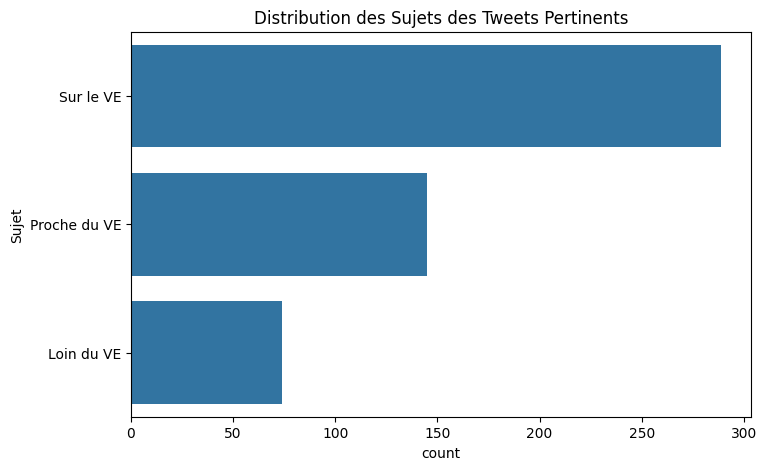

In [307]:
# verrifier si les tweets pertinents sont bien classés
plt.figure(figsize=(8, 5))
sns.countplot(y='Sujet', data=relevant_tweets, order=relevant_tweets['Sujet'].value_counts().index)
plt.title("Distribution des Sujets des Tweets Pertinents")
plt.show()

In [308]:
# verrifier si les tweets pertinents sont bien classés par un tableau
print(relevant_tweets['Sujet'].value_counts())

Sujet
Sur le VE       289
Proche du VE    145
Loin du VE       74
Name: count, dtype: int64


In [309]:
# Calculer le pourcentage de tweets pertinents par catégorie
total_tweets = df['Sujet'].value_counts()
relevant_tweets_count = relevant_tweets['Sujet'].value_counts()
percentage_relevant_tweets = (relevant_tweets_count / total_tweets) * 100

print(percentage_relevant_tweets)

Sujet
Loin du VE      11.384615
Proche du VE    18.354430
Sur le VE       42.375367
Name: count, dtype: float64
